In [1]:
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import fitsio
import desimodel.io
import desitarget.mtl
import desisim.quickcat
from astropy.io import fits
from astropy.table import Table, Column, vstack
import json
import shutil
import healpy
import mtl as mymtl
import targets


from desitarget.targetmask import desi_mask, obsconditions
from collections import Counter
import subprocess

%matplotlib inline

# Global statistics

In [2]:
def consolidate_favail(fba_files):
    # getting all the targetids of the assigned fibers
    print('reading individual fiberassign files')
    favail = list()
    for i_tile, tile_file in enumerate(fba_files):
        if i_tile%50 ==0:
            print(i_tile)
        id_favail, header = fits.getdata(tile_file, 'FAVAIL', header=True)
        favail.extend(id_favail['TARGETID'])
    return list(set(favail))

def global_efficiency(targets, id_avail, zcat, target_class='QSO', zcat_spectype='QSO', z_max=None, z_min=None):
    ii_avail = np.in1d(targets['TARGETID'], id_avail)
    targets_avail = targets[ii_avail]

    if z_max is None and z_min is None:
        sub_zcat = zcat.copy()
    elif (z_min is not None) or (z_max is not None):
        if z_max is not None:
            sub_zcat = zcat[zcat['Z']<z_max]
        if z_min is not None:
            sub_zcat = zcat[zcat['Z']>z_min]
    else:
        print("Error")
        sub_zcat = None

    # input target consistent with target_class
    is_class = (targets_avail['DESI_TARGET'] & desi_mask.mask(target_class))!=0
    targets_avail_class = targets_avail[is_class]
    n_avail = len(targets_avail_class)

    # output in the redshift catalog consistent with truth_spectype
    sub_zcat_class = sub_zcat[sub_zcat['SPECTYPE']==zcat_spectype]
    
    # keep the elements in the zcat that correspond to the correct input target class
    id_intersection = np.in1d(sub_zcat_class['TARGETID'], targets_avail_class['TARGETID'])
    sub_zcat_class = sub_zcat_class[id_intersection]
    n_assigned = len(sub_zcat_class)

    nobs = dict()
    for i in range(10):
        nobs[i] = np.count_nonzero(sub_zcat_class['NUMOBS']==i)
    nobs[0] = (n_avail - n_assigned)

    print(target_class, zcat_spectype, n_assigned/n_avail, n_avail, n_assigned, nobs)
    
def tile_efficiency(qa_json_file):
    f = open(qa_json_file)
    qa_dict = json.load(f)
    f.close()
    assign_total = []
    assign_science= []
    assign_sky = []
    assign_std = []
    for k in qa_dict:
        assign_total.append(qa_dict[k]['assign_total'])
        assign_science.append(qa_dict[k]['assign_science'])
        assign_sky.append(qa_dict[k]['assign_sky'])
        assign_std.append(qa_dict[k]['assign_std'])
    assign_total = np.array(assign_total)
    assign_science = np.array(assign_science)
    assign_sky = np.array(assign_sky)
    assign_std = np.array(assign_std)
    n_not_enough_sky = np.count_nonzero(assign_sky<400)
    n_not_enough_std = np.count_nonzero(assign_std<100)
    f_unassigned = (5000 - assign_total)/5000
    print(n_not_enough_sky, n_not_enough_std, np.median(f_unassigned))

In [3]:
! mkdir strategy_A/fiberassign_full
! cp strategy_A/fiberassign_dark0/*.fits strategy_A/fiberassign_full/
! cp strategy_A/fiberassign_dark1/*.fits strategy_A/fiberassign_full/
! cp strategy_A/fiberassign_dark2_dark3/*.fits strategy_A/fiberassign_full/
! cp strategy_A/fiberassign_gray/*.fits strategy_A/fiberassign_full/
! fba_run_qa --dir strategy_A/fiberassign_full/

mkdir: cannot create directory ‘strategy_A/fiberassign_full’: File exists
INFO: Reading fiber positions from /global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/desimodel/master/data/focalplane/fiberpos-all.fits
INFO: Found 245 fiberassign tile files
INFO: Selecting 245 fiberassign tile files
INFO: Processing tile 11227
INFO: Processing tile 22743
INFO: Processing tile 28485
INFO: Processing tile 5467
INFO: Processing tile 16998
INFO: Processing tile 22695
INFO: Processing tile 22723
INFO: Processing tile 22719
INFO: Processing tile 22717
INFO: Processing tile 5469
INFO: Processing tile 16953
INFO: Processing tile 5427
INFO: Processing tile 22715
INFO: Processing tile 5431
INFO: Processing tile 11220
INFO: Processing tile 16970
INFO: Processing tile 28461
INFO: Processing tile 5441
INFO: Processing tile 11237
INFO: Processing tile 16951
INFO: Processing tile 5477
INFO: Processing tile 5459
INFO: Processing tile 11206
INFO: Processing tile 28507
INFO: Processing tile 16

In [75]:
fba_files_A = glob.glob('strategy_A/fiberassign_full/tile-*fits')
favail_A = consolidate_favail(fba_files_A)
zcat_A = Table.read('strategy_A/zcat/dark2_dark3_zcat.fits')
tile_efficiency('strategy_A/fiberassign_full/qa.json')
targets = Table.read("targets/subset_dr8_mtl_dark_gray_NGC.fits")
truth = Table.read("targets/subset_truth_dr8_mtl_dark_gray_NGC.fits")
targets.sort(keys='TARGETID')
zcat_A.sort(keys='TARGETID')
truth.sort(keys='TARGETID')


reading individual fiberassign files
0
50
100
150
200
0 0 0.0


In [77]:
truth[:10]

TARGETID,MOCKID,TRUEZ,TRUESPECTYPE,TEMPLATETYPE,TEMPLATESUBTYPE,TEMPLATEID,SEED,MAG,MAGFILTER,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4
,,,,,,,,mag,,nanomaggies,nanomaggies,nanomaggies,nanomaggies,nanomaggies,nanomaggies,nanomaggies
int64,int64,float32,str10,str10,str10,int32,int64,float32,str15,float32,float32,float32,float32,float32,float32,float32
35185639641057490,35185639641057490,1.5,GALAXY,ELG,,-1,-1,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35185639641057512,35185639641057512,0.2,GALAXY,BGS,,-1,-1,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35185639641057541,35185639641057541,0.2,GALAXY,BGS,,-1,-1,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35185639641057545,35185639641057545,1.5,GALAXY,ELG,,-1,-1,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35185639641057557,35185639641057557,1.5,GALAXY,ELG,,-1,-1,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35185639641057558,35185639641057558,1.5,GALAXY,ELG,,-1,-1,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35185639641057560,35185639641057560,1.5,GALAXY,ELG,,-1,-1,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35185639641057589,35185639641057589,2.0,QSO,QSO,,-1,-1,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
avail_a_array = np.array([favail_A])
avail = Table(np.transpose(avail_a_array), names=(['TARGETID']))
avail.write("available.fits", overwrite=True)
avail = Table.read("available.fits")

In [81]:
compiled = targets.copy()
ii = np.in1d(targets['TARGETID'], avail['TARGETID'])
compiled = targets[ii]

In [85]:
compiled['NUMOBS'] = np.zeros(len(compiled), dtype=int)
compiled['Z'] = np.zeros(len(compiled))
compiled['TRUEZ'] = np.zeros(len(compiled), dtype=int)
compiled['TRUESPECTYPE'] = np.repeat('A', len(compiled))


ii_from_z = np.in1d(compiled['TARGETID'], zcat_A['TARGETID'])
compiled['Z'][ii_from_z] = zcat_A['Z']
compiled['NUMOBS'][ii_from_z] = np.int_(zcat_A['NUMOBS'])

ii_from_truth = np.in1d(truth['TARGETID'], compiled['TARGETID'])
compiled['TRUESPECTYPE'] = truth['TRUESPECTYPE'][ii_from_truth]
compiled['TRUEZ'] = truth['TRUEZ'][ii_from_truth]

In [86]:
compiled[['RA', 'DEC', 'TARGETID', 'DESI_TARGET', 'NUMOBS', 'TRUESPECTYPE', 'TRUEZ']].write("myzcat_strategy_A.fits", overwrite=True)

In [87]:
compiled=Table.read("myzcat_strategy_A.fits")

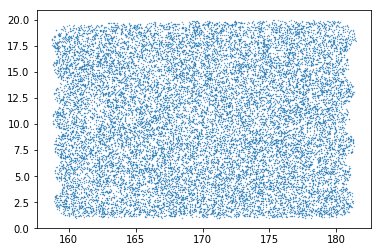

In [88]:
rr = np.random.random(len(compiled))
ii = rr<0.01
plt.scatter(compiled['RA'][ii], compiled['DEC'][ii], s=0.1)

In [89]:
compiled

RA,DEC,TARGETID,DESI_TARGET,NUMOBS,TRUESPECTYPE,TRUEZ
float64,float64,int64,int64,int64,str10,float32
160.244745614,1.07382533959,35185784596205324,131074,0,GALAXY,1.5
160.241563531,1.07734860895,35185784596205398,131074,0,GALAXY,1.5
160.241356949,1.08569498447,35185784596205576,268501001,0,GALAXY,0.7
160.244263567,1.08971713168,35185784596205676,268501001,1,GALAXY,0.7
160.245842685,1.08926537227,35185784596205677,268501001,0,GALAXY,0.7
160.191576997,1.09551093727,35185784596205797,1152921504606846976,0,GALAXY,0.2
160.237840836,1.10039400555,35185784596205877,131074,0,GALAXY,1.5
160.244733226,1.10021181741,35185784596205893,131074,0,GALAXY,1.5
160.196486656,1.10572999321,35185784596205975,131074,1,GALAXY,1.5


In [5]:
global_efficiency(targets, favail_A, zcat_A, target_class='QSO', zcat_spectype='QSO')
global_efficiency(targets, favail_A, zcat_A, target_class='LRG', zcat_spectype='GALAXY')
global_efficiency(targets, favail_A, zcat_A, target_class='ELG', zcat_spectype='GALAXY')
global_efficiency(targets, favail_A, zcat_A, target_class='QSO', zcat_spectype='QSO', z_min=2.15)
global_efficiency(targets, favail_A, zcat_A, target_class='QSO', zcat_spectype='QSO', z_max=2.15)
global_efficiency(targets, favail_A, zcat_A, target_class='LRG_1PASS', zcat_spectype='GALAXY')
global_efficiency(targets, favail_A, zcat_A, target_class='LRG_2PASS', zcat_spectype='GALAXY')

QSO QSO 0.9756803246151811 113365 110608 {0: 2757, 1: 69559, 2: 14998, 3: 15169, 4: 9047, 5: 1760, 6: 75, 7: 0, 8: 0, 9: 0}
LRG GALAXY 0.9053636000450722 195242 176765 {0: 18477, 1: 135074, 2: 35040, 3: 6394, 4: 257, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
ELG GALAXY 0.5939613368064967 1051491 624545 {0: 426946, 1: 624544, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
QSO QSO 0.1677325453182199 113365 19015 {0: 94350, 1: 1592, 2: 3434, 3: 7594, 4: 5302, 5: 1048, 6: 45, 7: 0, 8: 0, 9: 0}
QSO QSO 0.8079477792969612 113365 91593 {0: 21772, 1: 67967, 2: 11564, 3: 7575, 4: 3745, 5: 712, 6: 30, 7: 0, 8: 0, 9: 0}
LRG_1PASS GALAXY 0.8920003415008965 140556 125376 {0: 15180, 1: 125376, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
LRG_2PASS GALAXY 0.9397103463409282 54686 51389 {0: 3297, 1: 9698, 2: 35040, 3: 6394, 4: 257, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}


In [6]:
! mkdir strategy_B/fiberassign_full
! cp strategy_B/fiberassign_dark0/*.fits strategy_B/fiberassign_full/
! cp strategy_B/fiberassign_dark1/*.fits strategy_B/fiberassign_full/
! cp strategy_B/fiberassign_dark2_dark3/*.fits strategy_B/fiberassign_full/
! cp strategy_B/fiberassign_gray/*.fits strategy_B/fiberassign_full/
! fba_run_qa --dir strategy_B/fiberassign_full/

mkdir: cannot create directory ‘strategy_B/fiberassign_full’: File exists
INFO: Reading fiber positions from /global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/desimodel/master/data/focalplane/fiberpos-all.fits
INFO: Found 245 fiberassign tile files
INFO: Selecting 245 fiberassign tile files
INFO: Processing tile 11227
INFO: Processing tile 11220
INFO: Processing tile 22715
INFO: Processing tile 28485
INFO: Processing tile 16953
INFO: Processing tile 5459
INFO: Processing tile 28482
INFO: Processing tile 28461
INFO: Processing tile 16998
INFO: Processing tile 28523
INFO: Processing tile 5467
INFO: Processing tile 5427
INFO: Processing tile 16951
INFO: Processing tile 5477
INFO: Processing tile 11222
INFO: Processing tile 16970
INFO: Processing tile 28460
INFO: Processing tile 11168
INFO: Processing tile 28508
INFO: Processing tile 22743
INFO: Processing tile 11237
INFO: Processing tile 22732
INFO: Processing tile 28516
INFO: Processing tile 11172
INFO: Processing tile

In [7]:
fba_files_B = glob.glob('strategy_B/fiberassign_full/tile-*fits')
favail_B = consolidate_favail(fba_files_B)
zcat_B = Table.read('strategy_B/zcat/dark2_dark3_zcat.fits')
tile_efficiency('strategy_B/fiberassign_full/qa.json')

reading individual fiberassign files
0
50
100
150
200
0 0 0.0


In [8]:
global_efficiency(targets, favail_B, zcat_B, target_class='QSO', zcat_spectype='QSO')
global_efficiency(targets, favail_B, zcat_B, target_class='LRG', zcat_spectype='GALAXY')
global_efficiency(targets, favail_B, zcat_B, target_class='ELG', zcat_spectype='GALAXY')
global_efficiency(targets, favail_B, zcat_B, target_class='QSO', zcat_spectype='QSO', z_min=2.15)
global_efficiency(targets, favail_B, zcat_B, target_class='QSO', zcat_spectype='QSO', z_max=2.15)
global_efficiency(targets, favail_B, zcat_B, target_class='LRG_1PASS', zcat_spectype='GALAXY')
global_efficiency(targets, favail_B, zcat_B, target_class='LRG_2PASS', zcat_spectype='GALAXY')

QSO QSO 0.975609756097561 113365 110600 {0: 2765, 1: 69637, 2: 14861, 3: 15288, 4: 8966, 5: 1766, 6: 82, 7: 0, 8: 0, 9: 0}
LRG GALAXY 0.9053584781962898 195242 176764 {0: 18478, 1: 135070, 2: 35072, 3: 6330, 4: 292, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
ELG GALAXY 0.6021440031345965 1051491 633149 {0: 418342, 1: 633148, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
QSO QSO 0.1677060821241124 113365 19012 {0: 94353, 1: 1583, 2: 3487, 3: 7628, 4: 5242, 5: 1035, 6: 37, 7: 0, 8: 0, 9: 0}
QSO QSO 0.8079036739734486 113365 91588 {0: 21777, 1: 68054, 2: 11374, 3: 7660, 4: 3724, 5: 731, 6: 45, 7: 0, 8: 0, 9: 0}
LRG_1PASS GALAXY 0.8919718830928598 140556 125372 {0: 15184, 1: 125372, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
LRG_2PASS GALAXY 0.9397652049884797 54686 51392 {0: 3294, 1: 9698, 2: 35072, 3: 6330, 4: 292, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
